<h1 align="center"> Online Retail Customer Segmentation</h1>
<br>


### Introduction
> This is a customer segmentation for a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. [Dataset](https://archive.ics.uci.edu/ml/datasets/Online+Retail#)

### Models behind
> The clustering was based on RFM segmentation (recency, frequency, and monetary). We tried these algorithms for clustering: 
>- Kmeans
>- Agglomerative
>- Spectral
>- DBSCAN
>- HDBSCAN


In [47]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import umap
import matplotlib.cm as cm
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import AgglomerativeClustering, SpectralClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram
from sklearn.neighbors.nearest_centroid import NearestCentroid
import plotly.express as px
from sklearn.metrics import silhouette_samples, silhouette_score
import hdbscan

### `General look at the data`

In [3]:
# read the dataset
data = pd.read_excel('./Online Retail.xlsx')

In [4]:
# show firs 5 rows
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
# get the shape of the data
data.shape

(541909, 8)

In [6]:
# ge the data types of the columns
data.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

<div class="alert alert-block alert-info">

<h5>We have 8 features</h5>
    
- InvoiceNo: Invoice number. If this code starts with letter 'c', it indicates a cancellation. Nominal<br>
- StockCode: Product (item) code. Nominal<br>
- Description: Product (item) name. Nominal<br>
- Quantity: The quantities of each product (item) per transaction. Numeric<br>
- InvoiceDate: Invice Date and time. Numeric, datetime<br>
- UnitPrice: Unit price. Numeric<br>
- CustomerID: Customer number. Nominal<br>
- Country: Country name. Nominal

<h5>541909 smaples</h5>

</div>

In [7]:
# check if there are missing data
data.isna().any()

InvoiceNo      False
StockCode      False
Description     True
Quantity       False
InvoiceDate    False
UnitPrice      False
CustomerID      True
Country        False
dtype: bool

In [8]:
# get the number of missing values
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

<div class="alert alert-block alert-info">

There are 135080 missing ids in the CustomerID column and 1454 missing description in the Description column

</div>

### `Features preprocessing`

#### - Dealing with missing data

>we will ignore the Description column (not important in the clustering precess) and just deal with the CustomerID column. Also, since the InvoiceNo has no missing data we will try to get the customer id by matching the invoice number

In [9]:
# get the percentage of the transactions that have missing customer ids
data.isnull().sum()['CustomerID']/data.shape[0]

0.249266943342886

In [10]:
# get the invoices that don't have customer ids
invoice_for_null_customers = data[data['CustomerID'].isna()]\
.apply(lambda row: row['InvoiceNo'],
       axis = 1).unique()

In [11]:
# get the number of these invoices
len(invoice_for_null_customers)

3710

In [12]:
# from that invoices list, check if the invoices have a customer id in other rows
# get if the dataframe is empty
data[data['InvoiceNo'].isin(invoice_for_null_customers)][data['CustomerID'].notna()].empty

<ipython-input-12-48ec90bbffbc>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data[data['InvoiceNo'].isin(invoice_for_null_customers)][data['CustomerID'].notna()].empty


True

<div class="alert alert-block alert-info">
20% of the transactions don't have customer ids. 3710 invoices don't have customer ids. We tried to get them using the invoice numbers but the problem is that the customer id is missing for all transactions that belong to the invoice. So we are going to drop them.

In [13]:
# drop transactions wih missing customer ids
data = data.dropna(axis=0, subset=['CustomerID'])

In [14]:
# check if there are missing data
data.isna().any()

InvoiceNo      False
StockCode      False
Description    False
Quantity       False
InvoiceDate    False
UnitPrice      False
CustomerID     False
Country        False
dtype: bool

<div class="alert alert-block alert-info">We notice that by dropping transactions with missing customer ids, the transactions with missing description disappeared, which means that the missing descriptions belong to the missing customers.

### `Feature engineering`

> RFM Segmentation. grouping data for each customer and extract these features: 
>- number of transactions. number of unique InvoiceNo per customer
>- total money spent. sum the price of all items purchased
>- recency. how long has it been since the customer last purchased in days




#### - cancelled  transactions

In [15]:
# slice cancelled transactions
cancelled_transactions = data[data['InvoiceNo'].str.get(0)=='C']

#### - confirmed transactions

In [16]:
# slice confirmed transactions
confirmed_transactions = data[~data['InvoiceNo'].isin(cancelled_transactions['InvoiceNo'])]

In [17]:
# find the total money spent for each stock in each invoice
confirmed_transactions["total_money"] = confirmed_transactions["Quantity"] * confirmed_transactions["UnitPrice"]

<ipython-input-17-ef4b54a02481>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confirmed_transactions["total_money"] = confirmed_transactions["Quantity"] * confirmed_transactions["UnitPrice"]


In [18]:
# show first 5 rows
confirmed_transactions.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_money
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [19]:
# get the shape
confirmed_transactions.shape

(397924, 9)

In [20]:
# convert the timestamp to just the date
confirmed_transactions["InvoiceDate"] = confirmed_transactions["InvoiceDate"].dt.date

# get the most recent day and increase it by one day
most_recent_day = max(confirmed_transactions.InvoiceDate) + datetime.timedelta(days=1)

<ipython-input-20-af08886bab53>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confirmed_transactions["InvoiceDate"] = confirmed_transactions["InvoiceDate"].dt.date


In [21]:
# group by customer id
grouped_confirmed_transactions = confirmed_transactions.groupby('CustomerID')\
        .agg(
            transactions = ('InvoiceNo', lambda x: x.nunique()), # number of transactions
            total_money = ('total_money', 'sum'), # sum the total money column to get all amount
            recency = ('InvoiceDate',lambda x: (most_recent_day - x.max()).days))\
        .reset_index()

In [22]:
grouped_confirmed_transactions.head()

,CustomerID,transactions,total_money,recency
0,12346.0,1,77183.60,326
1,12347.0,7,4310.00,3
2,12348.0,4,1797.24,76
3,12349.0,1,1757.55,19
4,12350.0,1,334.40,311


In [23]:
# drop the customer id 
clustering_data = grouped_confirmed_transactions.drop('CustomerID', 1)

In [24]:
# show first 5 rows
clustering_data.head()

,transactions,total_money,recency
0,1,77183.60,326
1,7,4310.00,3
2,4,1797.24,76
3,1,1757.55,19
4,1,334.40,311


### `EDA`

In [25]:
def show_distribution(feature):
    """plot the distribution, box plot, and statistics (min, max, mean, median, and mode)
    
    [param]: dataframe feautre
    """
    # get statistics
    min_val = feature.min()
    max_val = feature.max()
    mean_val = feature.mean()
    med_val = feature.median()
    mod_val = feature.mode()[0]

    
    # create a figure for 2 subplots (2 rows, 1 column)
    f, axes = plt.subplots(2, 1,  figsize = (15,7))

    # plot the distribution   
    sns.distplot(feature,
             hist = False,
             kde = True, 
             kde_kws = {'shade': True, 'linewidth': 2},  
             color ="red", ax=axes[0])
    
    # plot the box plot
    sns.boxplot( data = feature, orient='h' , ax=axes[1])
    
    # add lines for the statistics
    axes[0].axvline(x=min_val, color = 'gray', linestyle='dashed', linewidth = 2)
    axes[0].axvline(x=mean_val, color = 'cyan', linestyle='dashed', linewidth = 2)
    axes[0].axvline(x=med_val, color = 'red', linestyle='dashed', linewidth = 2)
    axes[0].axvline(x=mod_val, color = 'yellow', linestyle='dashed', linewidth = 2)
    axes[0].axvline(x=max_val, color = 'gray', linestyle='dashed', linewidth = 2)

    # add title to the figure
    f.suptitle('Data Distribution')
    
    # print the statistics
    print('Minimum:{:.2f}\nMean:{:.2f}\nMedian:{:.2f}\nMode:{:.2f}\nMaximum:{:.2f}\n'.format(min_val,
                                                                                            mean_val,
                                                                                            med_val,
                                                                                            mod_val,
                                                                                            max_val))


#### - transactions

Minimum:1.00
Mean:4.27
Median:2.00
Mode:1.00
Maximum:210.00



/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


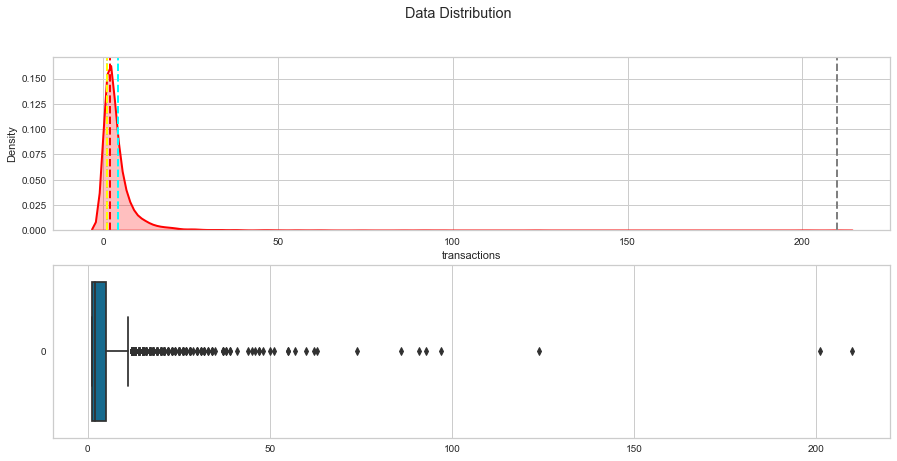

In [26]:
# get the variable to examine
transactions = clustering_data['transactions']

# show distribution
show_distribution(transactions)

#### - total_money

Minimum:0.00
Mean:2053.79
Median:674.45
Mode:76.32
Maximum:280206.02



/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


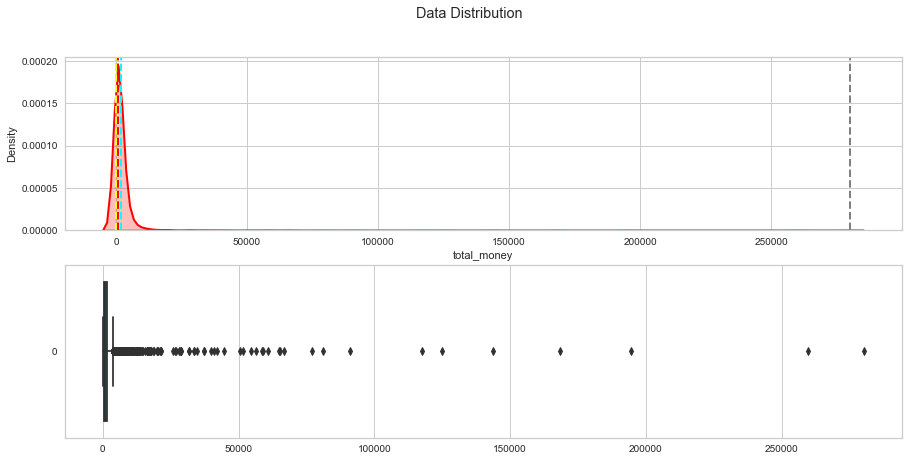

In [27]:
# get the variable to examine
total_money = clustering_data['total_money']

# show distribution
show_distribution(total_money)

In [28]:
# delete the customer with zero money spent
clustering_data = clustering_data[clustering_data['total_money']>0]

#### - recency

Minimum:1.00
Mean:93.06
Median:51.00
Mode:2.00
Maximum:374.00



/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


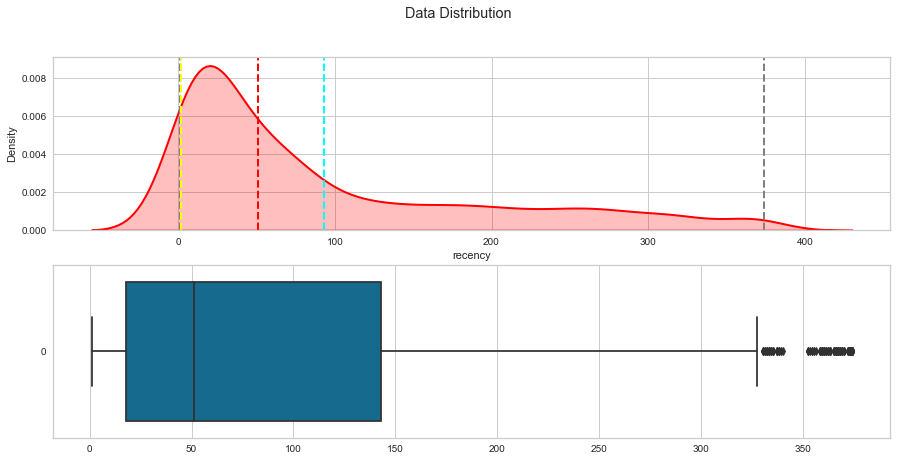

In [29]:
# Get the variable to examine
recency = clustering_data['recency']

# show distribution
show_distribution(recency)

<div class="alert alert-block alert-info">All distributions are right-skewed having outliers. recency feature has fewer outliers than other features. we will try to solve these problems by doing box-cox transformation.

In [30]:
# copy the dataset to use in the business interpretation
original_clustering_data = clustering_data.copy()

### `Feature engineering`

In [31]:
def plot_all_features(dataframe):
    """plot the distribution and the box plot for the dataframe feautres
    
    [param]: the dataframe
    """
    # create a figure for 2 subplots (4 rows, 2 column)
    f, axes = plt.subplots(3, 2,  figsize = (15,10))
    
    # add title to the figure
    f.suptitle('Data Distribution')
    
    # get feautre names
    numeric_feature_names = list(dataframe.columns)

    # go over each feature  
    for column in numeric_feature_names:
        
        # plot the distribution
        sns.distplot(dataframe[column],
                     hist = False,
                     kde = True, 
                     kde_kws = {'shade': True, 'linewidth': 2},  
                     color ="red", ax=axes[numeric_feature_names.index(column)][0])
        
        # plot the box plot 
        sns.boxplot( data = dataframe[column], orient='h' , ax=axes[numeric_feature_names.index(column)][1])
        
    # improve spaces
    f.tight_layout()
    

#### Box-Cox transform

In [32]:
clustering_data.head()

,transactions,total_money,recency
0,1,77183.60,326
1,7,4310.00,3
2,4,1797.24,76
3,1,1757.55,19
4,1,334.40,311


In [33]:
# go over the features 
for column in list(clustering_data.columns):
    
    # get the optimal lambda
    l, opt_lambda = stats.boxcox(np.array(clustering_data[column]))
    
    # transform the features
    clustering_data[column] = stats.boxcox(clustering_data[column],lmbda=opt_lambda)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdep

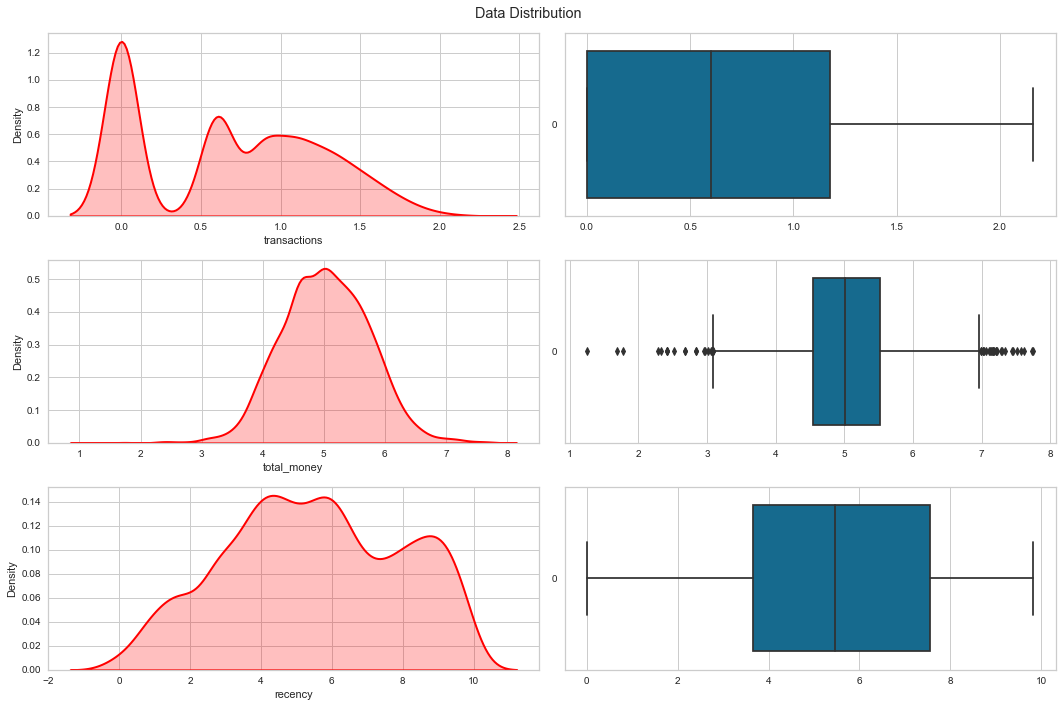

In [34]:
# plot after doing tranformations
plot_all_features(clustering_data)

<div class="alert alert-block alert-info"> After doing transformations there are no outliers in the transactions and recency features. The distribution fo the total_money and recency features became almost normal distribution, but still, there are outliers in the total_money. 

#### feature normalization

In [35]:
# fit scaler on data
norm = StandardScaler().fit(clustering_data)

# transform data
fearures_normalized = norm.transform(clustering_data)

# rename columns
data_normalized = pd.DataFrame(fearures_normalized).\
rename(columns={0: "transactions", 1: "total_money", 2:"recency"}) 

In [36]:
data_normalized.head()

,transactions,total_money,recency
0,-1.184670,3.144114,1.620274
1,1.159262,1.376049,-1.738803
2,0.664605,0.749774,0.299813
3,-1.184670,0.733175,-0.703409
4,-1.184670,-0.591544,1.572616


In [37]:
# add the normalized features to the dataframe
clustering_data = data_normalized

<AxesSubplot:>

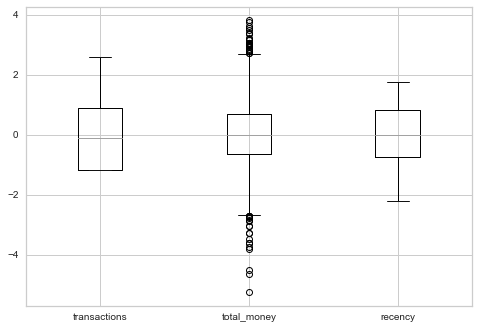

In [38]:
# box plot for the normlized data
clustering_data.boxplot()

<div class="alert alert-block alert-info"> We can see that all features now in the same scale

### `Data visualization`

### - UMAP and dimentionality reduction 

In [39]:
# define a umap object and reduce the dimentionality to 2 dim
reducer = umap.UMAP(n_components=2)

# reduce the dimentionality of the data
umap_model = reducer.fit(clustering_data)
clustering_data_embedding = umap_model.transform(clustering_data)

In [41]:
def plot_clusters(clusters = np.zeros(clustering_data_embedding.shape[0]), centers = []):
    """plot a scatter plot for the reduced data, and plot the clusters centers if provided
    
    [param]: clusters: the clusters to use them in the points coloring
    [param]: centers: the cluster centers
    """
    # scatter plot 
    plt.scatter(clustering_data_embedding[:, 0], clustering_data_embedding[:, 1], c=clusters, s=50, cmap='viridis')
    
    # if centers are passed plot them
    if len(centers):
        
        # transform the centers into 2d
        centers_embedding = umap_model.transform(centers)

        # plot the centers
        plt.scatter(centers_embedding[:, 0], centers_embedding[:, 1], c='black', s=200, alpha=0.5);

    # show the plot
    plt.show()

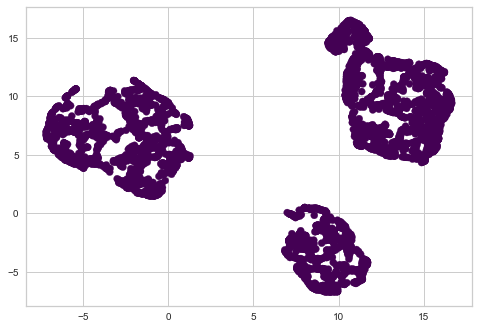

In [42]:
# plot the data in 2d
plot_clusters()

<div class="alert alert-block alert-info">It seems that there are 3 separated clusters.

### `Kmeans clustering`

### - Elbow method

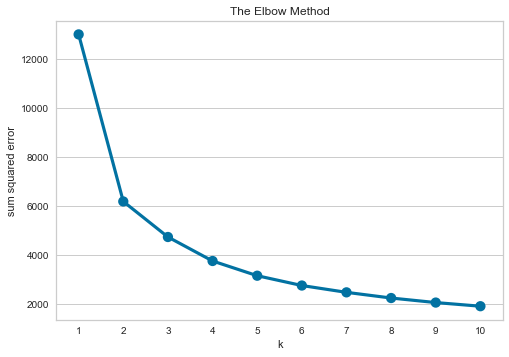

In [48]:
# define the sum of squared errors for each K value
sum_squared_error = {}

# go over each K and get the error
for k in range(1, 11):
    
    # define a kmeans object using the k number of clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    
    # fit the kmeans model
    kmeans.fit(clustering_data)
    
    # sse to closest cluster centroid
    sum_squared_error[k] = kmeans.inertia_

# plot the sse for each k
sns.pointplot(x=list(sum_squared_error.keys()), y=list(sum_squared_error.values()))

# customize the chart
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('sum squared error')

# show figure
plt.show()

<div class="alert alert-block alert-info">From the Elbow method plot we can see the sum of squared error for each k (number of clusters). After k = 2 the SSE start decreasing in a linear fashion which indicates that the best number of clusters is 2.

### - Silhouette method

In [49]:
def silhouette_plot(clusterer, n_clusters, model_name):
    """plot the Silhouette for clusters
    
    [param]: clusterer: the cluster model
    [param]: n_clusters: the number of clusters
    [param]: model_name: the name of the clusterer
    """
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots()
    fig.set_size_inches(15, 5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(clustering_data) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value 
    cluster_labels = clusterer.fit_predict(clustering_data)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(clustering_data, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(clustering_data, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for "+model_name)
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--", label = "Average silhouette score")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.legend()
    plt.show()

For n_clusters = 2 The average silhouette_score is : 0.4316102820952384


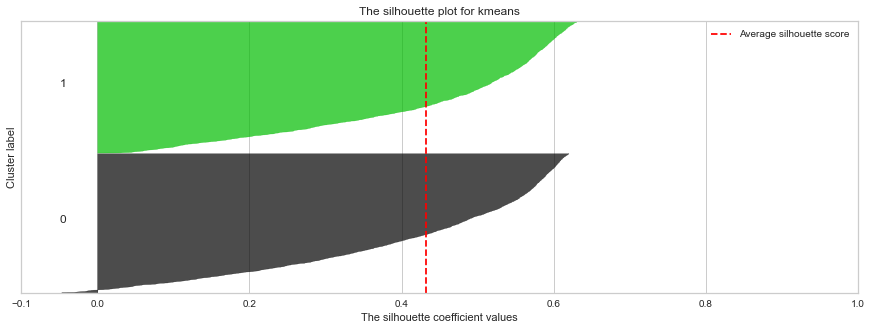

For n_clusters = 3 The average silhouette_score is : 0.3327126026238429


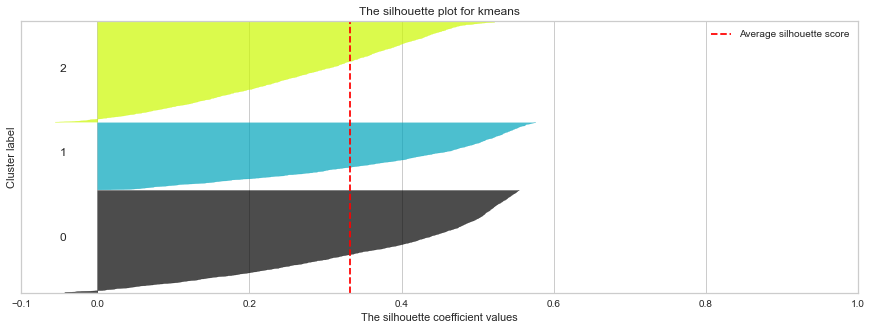

For n_clusters = 4 The average silhouette_score is : 0.33410117882456103


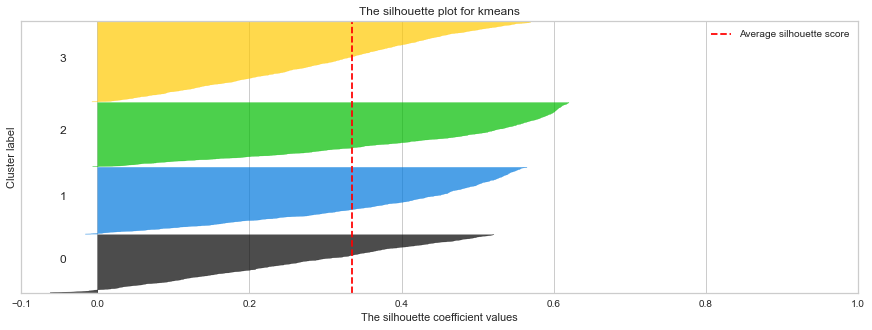

For n_clusters = 5 The average silhouette_score is : 0.32650613406768614


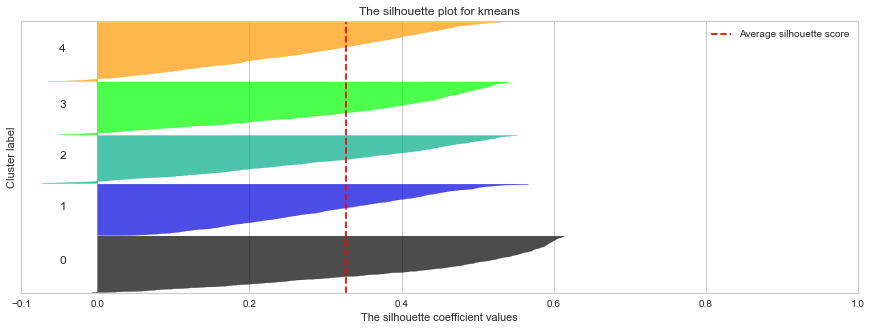

In [50]:
# define the values of k to test
potential_k = list(range(2, 6))

# go over each k value
for k in potential_k:
    
    
    # create KMeans instance for different number of clusters
    kmeans = KMeans(n_clusters=k)
    
    # plot the silhouette
    silhouette_plot(kmeans, k, "kmeans")

<div class="alert alert-block alert-info">All clusters in the three plots are above the average silhouette scores. The values of n_clusters as 4 and 5 look to be suboptimal because there are many points that are overlapped to different clusters that lie on the negative side and the average silhouette score is the lowest. The values of n_clusters as 2 and 3 look to be optimal. However, when n_clusters is 2 the proportion of the overlapped points less than when n_clusters is 3. Also, the average silhouette score for n_clusters as 2 is larger than n_clusters as 3. In conclusion, the optimal n_clusters is 2.

### - Visualizing the clusters in 2D

In [51]:
# define a kmeans object setting 3 for number of clusters
kmeans = KMeans(n_clusters=2)

# predict the clusters
y_kmeans = kmeans.fit_predict(clustering_data)

# get the centroids
kmeans_centers = kmeans.cluster_centers_

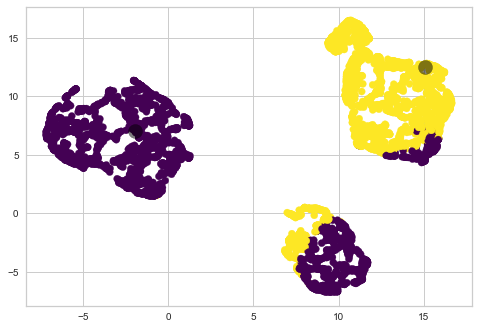

In [52]:
# plot the clusters in 2d
plot_clusters(y_kmeans, kmeans_centers)

<div class="alert alert-block alert-info">We can see that Kmeans didn't do a good job, the clusters are overlapped. Kmeans is not the best choice to use.

### `Agglomerative clustering`

### - Dendrogram

In [53]:
# define an agglomerative clustering object whout specify the number of clusters
agglomerative = AgglomerativeClustering(distance_threshold=0,
                                        n_clusters=None,
                                        linkage='ward',
                                        affinity='euclidean')

# fit the model
agglo_model = agglomerative.fit(clustering_data)

In [54]:
def plot_dendrogram(model, **kwargs):
    """plot the dendrogram which represents the hierarchy of the clusters
    
    [param]: model: the clusterer object
    """
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

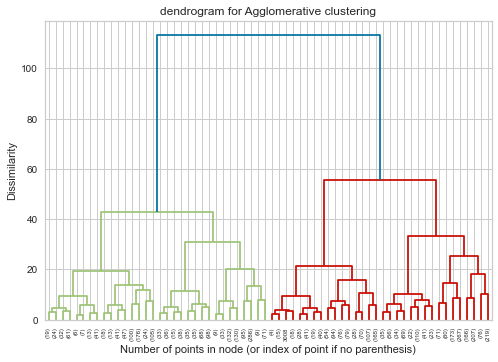

In [55]:
# plot the dendrogram on five levels
plot_dendrogram(agglo_model, truncate_mode='level', p=5)

# add plot title, x axis label , and y axis label
plt.title("dendrogram for Agglomerative clustering")
plt.xlabel("Number of points in node (or index of point if no parenthesis)")
plt.ylabel("Dissimilarity")
plt.show()

<div class="alert alert-block alert-info">From the dendrogram, we can see three clusters
as three branches that exist at about the same horizontal distance. We can get the three clusters by cutting the tree at distance 50. It seems that there are no outliers.

### - Visualizing the clusters in 2D


In [56]:
def find_centoids(clusters):
    """find the center of the clusters
    
    [param]: clusters: the clusters of the data we got from the model
    [return]: the center points
    """
    # define NearestCentroid object
    centroid_finder = NearestCentroid()

    # fit the NearestCentroid
    centroid_finder.fit(clustering_data, clusters)

    # get centroids
    return(centroid_finder.centroids_)

In [57]:
# define an agglomerative clustering object with 3 clusters
agglomerative_three_clusters = AgglomerativeClustering(distance_threshold=None,
                                        n_clusters=3,
                                        linkage='ward',
                                        affinity='euclidean')


# get the clusters
agglo_cluster_labels = agglomerative_three_clusters.fit_predict(clustering_data)

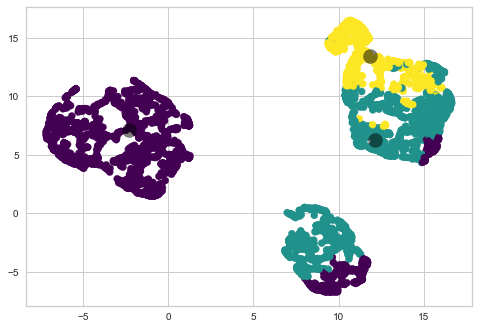

In [58]:
# plot the clusters in 2d
plot_clusters(agglo_cluster_labels, find_centoids(agglo_cluster_labels))

<div class="alert alert-block alert-info">Agglomerative clustering gave us 3 clusters, they are overlapped. It just identified one pure cluster. However, Agglomerative gave us better results then Kmeans. 

### - Silhouette method

For n_clusters = 3 The average silhouette_score is : 0.30984687643385833


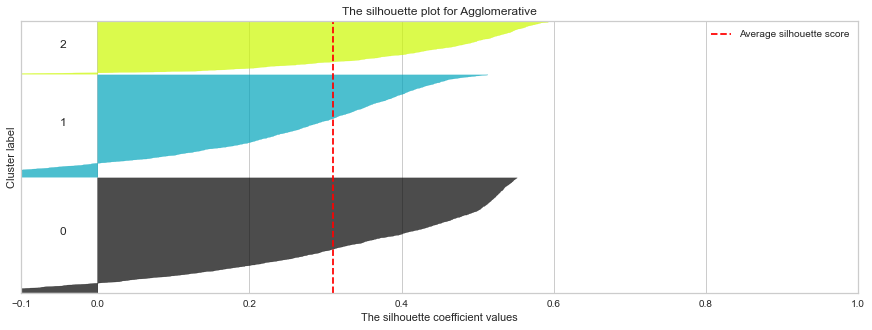

In [59]:
# plot the silhouette when n_clusters is 3
silhouette_plot(agglomerative_three_clusters, 3, "Agglomerative")

<div class="alert alert-block alert-info">The three clusters are above the average Silhouette score. All clusters have some values on the negative side which explains the overlapped clusters in the visualization.



### `Spectral clustering`

### - Silhouette method

For n_clusters = 2 The average silhouette_score is : 0.38931178325473986


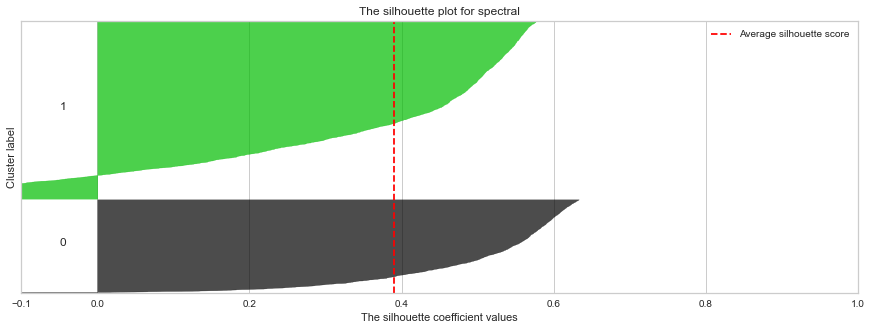

For n_clusters = 3 The average silhouette_score is : 0.24226110674936552


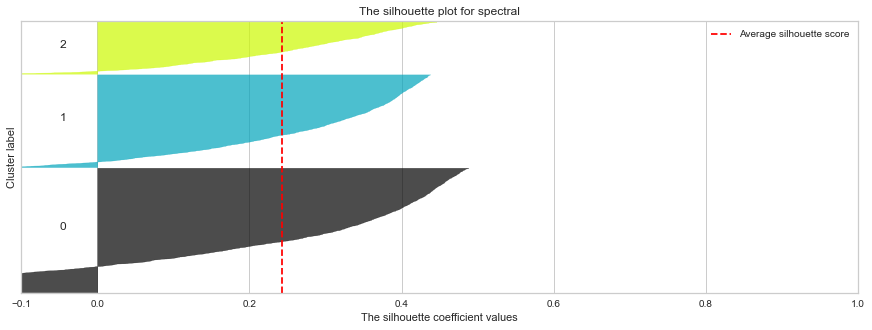

For n_clusters = 4 The average silhouette_score is : 0.21655916302762224


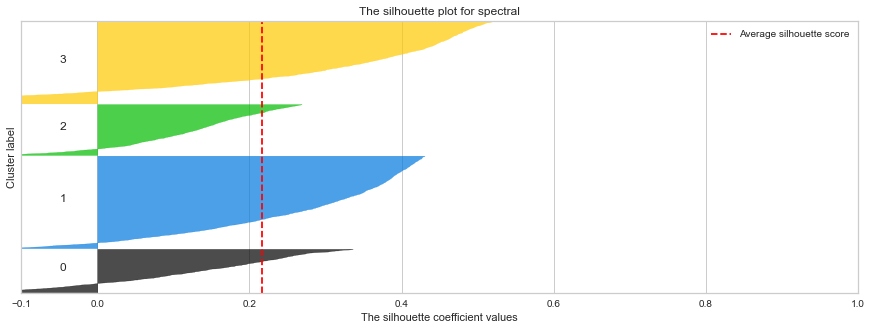

In [105]:
# define the values of k to test
potential_k = list(range(2, 5))

# go over each k value
for k in potential_k:
    
    # create spectral instance for different number of clusters
    spectral_model = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', n_components=3)
    
    # plot the silhouette
    silhouette_plot(spectral_model, k, "spectral")

<div class="alert alert-block alert-info">All clusters are above the average silhouette score. Although, when n_clusters is 4 the number of overlapped points is larger. When n_cluster is 2 the average silhouette score larger than n_clusters as 3, considering the 2d visualization choosing n_clusters as 3 makes more sense.

### - Visualizing the clusters in 3D


In [114]:
# create spectral instance for 3 number of clusters
spectral_model = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', n_components=3)


# get the clusters
spectral__labels = spectral_model.fit_predict(clustering_data)

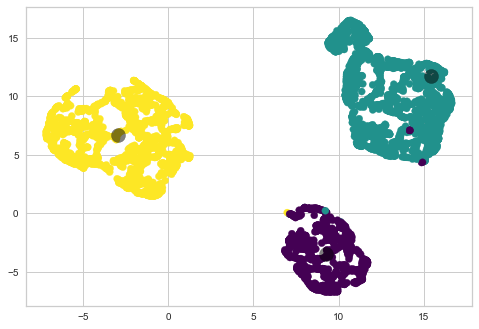

In [115]:
# plot clusters in 2d
plot_clusters(spectral__labels, find_centoids(spectral__labels))

<div class="alert alert-block alert-info">The Spectral clustering gave us 3 separated clusters, they are few overlapped points. This is the best result so far.

### `DBSCAN clustering`

In [63]:
# create a dbscan object setting the eps as 0.6 and the min smaple in the cluster is 50
dbscan = DBSCAN(eps=0.6, min_samples=50, metric='euclidean')

# fit the model and get the clusters
dbscan_clusters = dbscan.fit_predict(clustering_data)

In [64]:
# get the clusters
set(dbscan_clusters)

{-1, 0, 1}

### - Visualizing the clusters in 2D


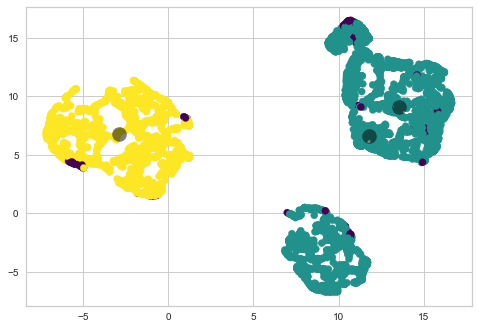

In [65]:
# plot the clusters in 2d
plot_clusters(dbscan_clusters, find_centoids(dbscan_clusters))

### - Silhouette method

For n_clusters = 2 The average silhouette_score is : 0.37087803612235004


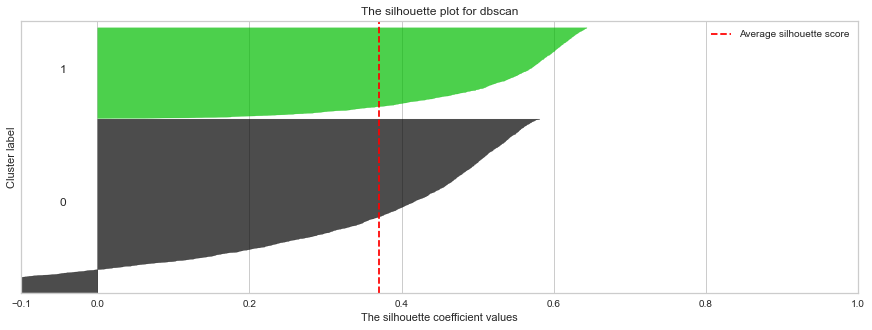

In [66]:
# plot the silhouette when n_clusters is 2
silhouette_plot(dbscan, 2, "dbscan")

<div class="alert alert-block alert-info">DBSCAN gave us 2 clusters. All cluster is above the average silhouette score, one of them has overlapped points. Still, the Spectral is the best so far.

### `HDBSCAN clustering`

In [67]:
# create an hdbscan object setting the min cluster size is 10 points
h_dbscan = hdbscan.HDBSCAN(min_cluster_size=10)

# fit the model and get the clusters
hdbscan_clusters = h_dbscan.fit_predict(clustering_data)

In [68]:
# the percentage of noise data points
((hdbscan_clusters == -1).sum()/hdbscan_clusters.sum())*100

2.4358130348913756

### - Visualizing the clusters in 3D


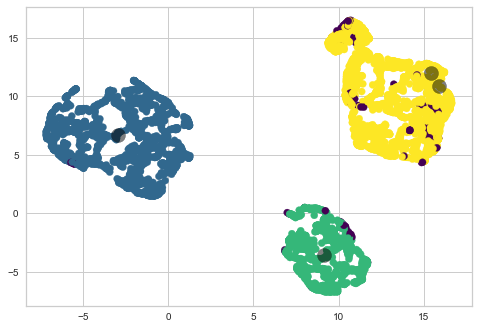

In [69]:
# plot the clusters in 2d
plot_clusters(hdbscan_clusters, find_centoids(hdbscan_clusters))

### - Silhouette method

For n_clusters = 3 The average silhouette_score is : 0.23088155474711283


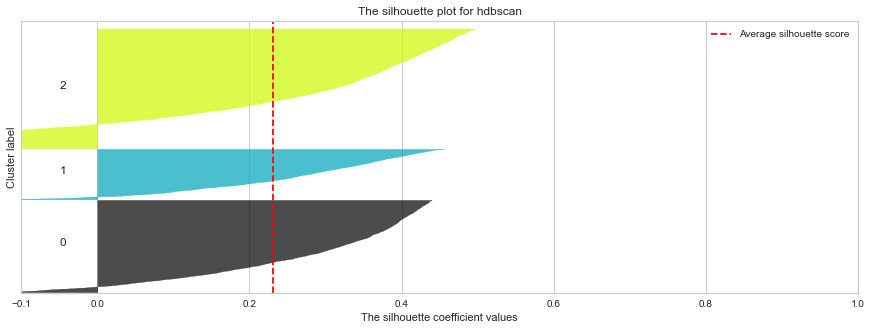

In [70]:
# plot the silhouette when n_clusters is 3
silhouette_plot(h_dbscan, 3, "hdbscan")

<div class="alert alert-block alert-info">HDBSCAN gave us 3 clusters, they are overlapped (a high proportion of points in the negative size). 3% of the data is considered as noises ( cluster -1). The Silhouette score is lower than Spectral. Still, the Spectralis the best. 

### `Business interpretation`

> We will discover the characteristics of each cluster produced by the Spectral algorithm. 

In [84]:
# copy the original dataframe
clustered_data = original_clustering_data.copy()

In [85]:
# add the cluster column
clustered_data['cluster'] = spectral__labels

In [86]:
clustered_data.head()

,transactions,total_money,recency,cluster
0,1,77183.60,326,1
1,7,4310.00,3,0
2,4,1797.24,76,0
3,1,1757.55,19,1
4,1,334.40,311,1


### - class 1

In [87]:
# sclice the customers belong to the first cluster
cluster_1 = clustered_data[clustered_data['cluster'] == 0].drop('cluster', 1)

In [88]:
cluster_1.head()

,transactions,total_money,recency
1,7,4310.00,3
2,4,1797.24,76
5,8,2506.04,37
9,3,2811.43,23
12,4,6372.58,58


In [89]:
# get the pecantage of those customers
cluster_1.shape[0]/clustered_data.shape[0]

0.46219455970493317

In [90]:
def distribution_cluster_feature(feature):
    """plot the distribution and statistics (min, max, mean, median, and mode)
    
    [param]: dataframe feautre
    """
    # get statistics
    min_val = feature.min()
    max_val = feature.max()
    mean_val = feature.mean()
    med_val = feature.median()
    mod_val = feature.mode()[0]

    
    # print the statistics
    print('Minimum:{:.2f}\nMean:{:.2f}\nMedian:{:.2f}\nMode:{:.2f}\nMaximum:{:.2f}\n'.format(min_val,
                                                                                            mean_val,
                                                                                            med_val,
                                                                                            mod_val,
                                                                                            max_val))

    # plot the distribution   
    sns.distplot(feature,
             hist = False,
             kde = True, 
             kde_kws = {'shade': True, 'linewidth': 2},  
             color ="red")
    plt.show()

#### - total_money, recency, transactions

Minimum:2.00
Mean:7.65
Median:5.00
Mode:3.00
Maximum:210.00



/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


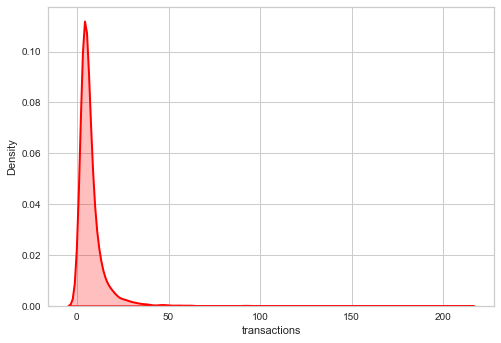

Minimum:167.50
Mean:3862.69
Median:1693.26
Mode:331.00
Maximum:280206.02



/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


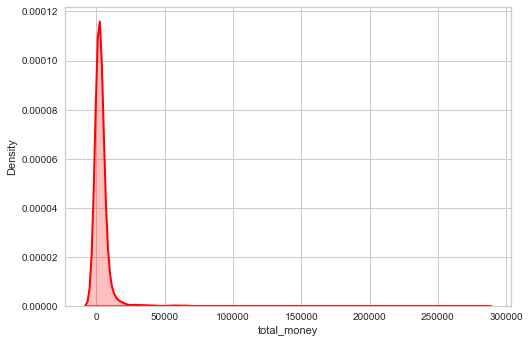

Minimum:1.00
Mean:44.77
Median:24.00
Mode:2.00
Maximum:373.00



/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


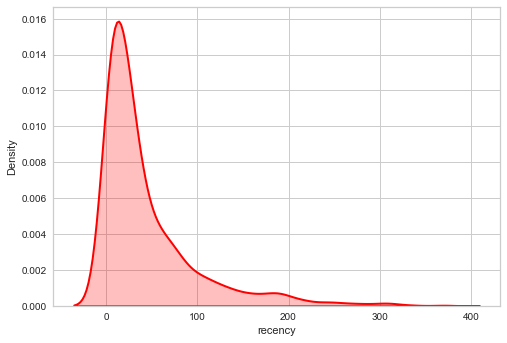

In [91]:
# show the distribution for the all features
for column in cluster_1.columns:
    
    # show the distribution
    distribution_cluster_feature(cluster_1[column])

<div class="alert alert-block alert-info">
The customers that belong to the first class have these characteristics:<br><br>
- they represent 46% of the customers<br>
- they have about 5 transactions<br>
- they spent about 1700 $<br>
- their transaction was before about 24 days<br>

<strong>These customers are the champions, best customers. They bought most recently and are heavy spenders.

### - class 2

In [92]:
# sclice the customers belong to the second cluster
cluster_2 = clustered_data[clustered_data['cluster'] == 1].drop('cluster', 1)

In [93]:
cluster_2.head()

,transactions,total_money,recency
0,1,77183.60,326
3,1,1757.55,19
4,1,334.40,311
6,1,89.00,205
7,1,1079.40,233


In [94]:
# get the pecantage of those customers
cluster_2.shape[0]/clustered_data.shape[0]

0.34439834024896265

#### - transactions

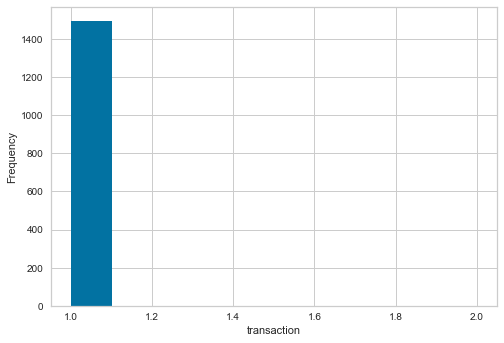

In [95]:
# hist for the transaction feature
cluster_2.transactions.plot.hist()

# customize plot
plt.xlabel('transaction')
plt.show()


#### - total_money and recency

Minimum:3.75
Mean:412.53
Median:257.51
Mode:76.32
Maximum:77183.60



/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


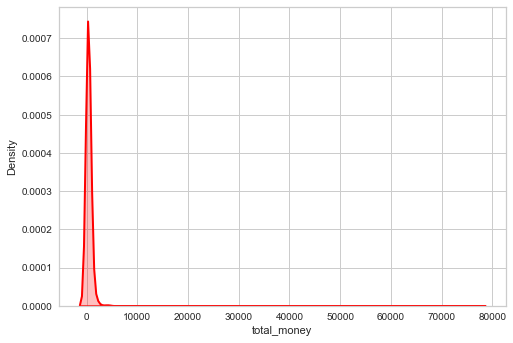

Minimum:1.00
Mean:157.15
Median:132.00
Mode:54.00
Maximum:374.00



/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


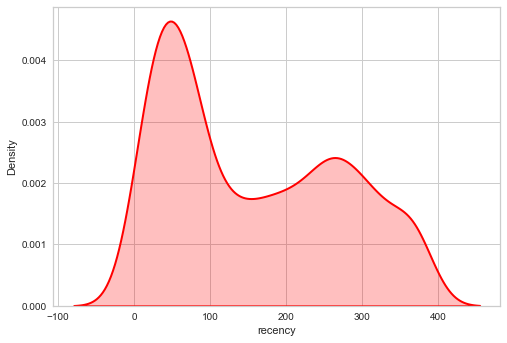

In [96]:
# show the distribution for the total_money and recency features
for column in ['total_money', 'recency']:
    
    # show the distribution
    distribution_cluster_feature(cluster_2[column])

<div class="alert alert-block alert-info">
   The customers that belong to the first class have these characteristics:<br><br>
- they represent about 34% of the customers<br>
- they have just one transaction<br>
- they spent about 260 $, a small number of them spent a high amount of money more than 20000 dollars 
    <br>
- their transaction was before about 150 days<br>

<strong> They are not loyalists, they purchased just once before a long time. They are churned customers.

### - class 3

In [97]:
# sclice the customers belong to the third cluster
cluster_3 = clustered_data[clustered_data['cluster'] == 2].drop('cluster', 1)

In [98]:
cluster_3.head()

,transactions,total_money,recency
11,2,1168.06,2
16,2,552.00,110
18,2,641.38,292
21,2,1887.96,45
25,2,457.50,11


In [99]:
# get the pecantage of those customers
cluster_3.shape[0]/clustered_data.shape[0]

0.1934071000461042

#### - total_money,  recency, transactions, transactions_cancelled

Minimum:2.00
Mean:2.02
Median:2.00
Mode:2.00
Maximum:6.00



/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


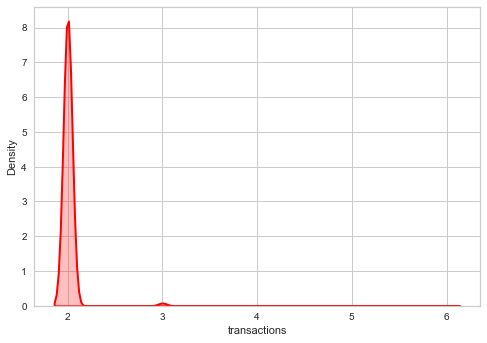

Minimum:36.56
Mean:656.01
Median:538.81
Mode:379.65
Maximum:4481.35



/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


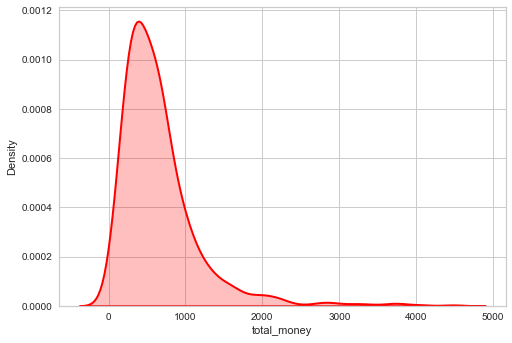

Minimum:2.00
Mean:94.34
Median:62.00
Mode:5.00
Maximum:374.00



/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


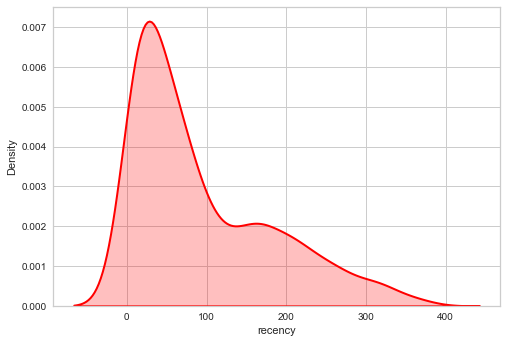

In [100]:
# show the distribution for the features
for column in cluster_3.columns:
    
    # show the distribution
    distribution_cluster_feature(cluster_3[column])

<div class="alert alert-block alert-info">
The customers that belong to the third class have these characteristics:<br><br>
- they represent 19% of the customers<br>
- they have about 2 transactions<br>
- they spent about 540$<br>
- their transaction was before about 60 days<br>

<strong>Since they purchased more than once with a good amount of money before a short period of time, these customers are new potential loyalists.